# 3. Modelling and Conclusions

##### <u> Contents </u>
- [Model Preparation](#Model-Preparation)
- [Modelling and Validation](#Modelling-and-Validation)
    - [Logistic Regression](#Logistic-Regression)
    - [Multinomial Naive-Bayes Model](#Multinomial-Naive-Bayes-Model)
- [Conclusions & Further Improvements](#Conclusions-&-Further-Improvements)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [2]:
data = pd.read_csv('./scifi_cleaned.csv')

## Model Preparation
Below I binarized the subreddit column to show startrek as the positive class. Binarization is useful for the sake of logistic regression modelling. If I was using other classification models such as kNN, I would not need to binarize the y-variable. There is a class imbalance but I will not be bootstrapping at this moment for the sake of preliminary model set up.

In [3]:
data = pd.DataFrame(data, columns = ['title','subreddit'])
data['subreddit']= data['subreddit'].replace({'StarWars':0,'startrek':1}) #binarizes outcome variable to is or isn't starwars
data.rename(columns = {'subreddit':'is_startrek'}, inplace = True)
data['is_startrek'].value_counts(normalize = True)

1    0.623198
0    0.376802
Name: is_startrek, dtype: float64

Before starting the modelling process, I will check to see if there are any other null values that were generated as a result of the language processing, and saving to a new csv file. 

In [4]:
#checking to see if language processing left any blanks after saving to csv and removing them
data.isnull().sum()

title          9
is_startrek    0
dtype: int64

9 titles were left blank after the language cleaning as a result of them containing urls, so when the results were saved to scifi_cleaned.csv, they were converted into NaNs. I will remove the NaNs and continue to build the models. 

In [5]:
null_titles = data.loc[data['title'].isnull()].index 
data.drop(index = null_titles, inplace = True) #drops 
data.reset_index(inplace= True)
data.drop(columns='index', inplace = True)
#data.drop(columns='level_0',inplace = True)
data.isnull().sum()

title          0
is_startrek    0
dtype: int64

After this last run of cleaning I wanted to check the word count distribution again.

In [6]:
cvec = CountVectorizer()
X = data['title']
titlevec = cvec.fit_transform(X) 
title_count = pd.DataFrame(titlevec.toarray(), 
                           columns = cvec.get_feature_names())

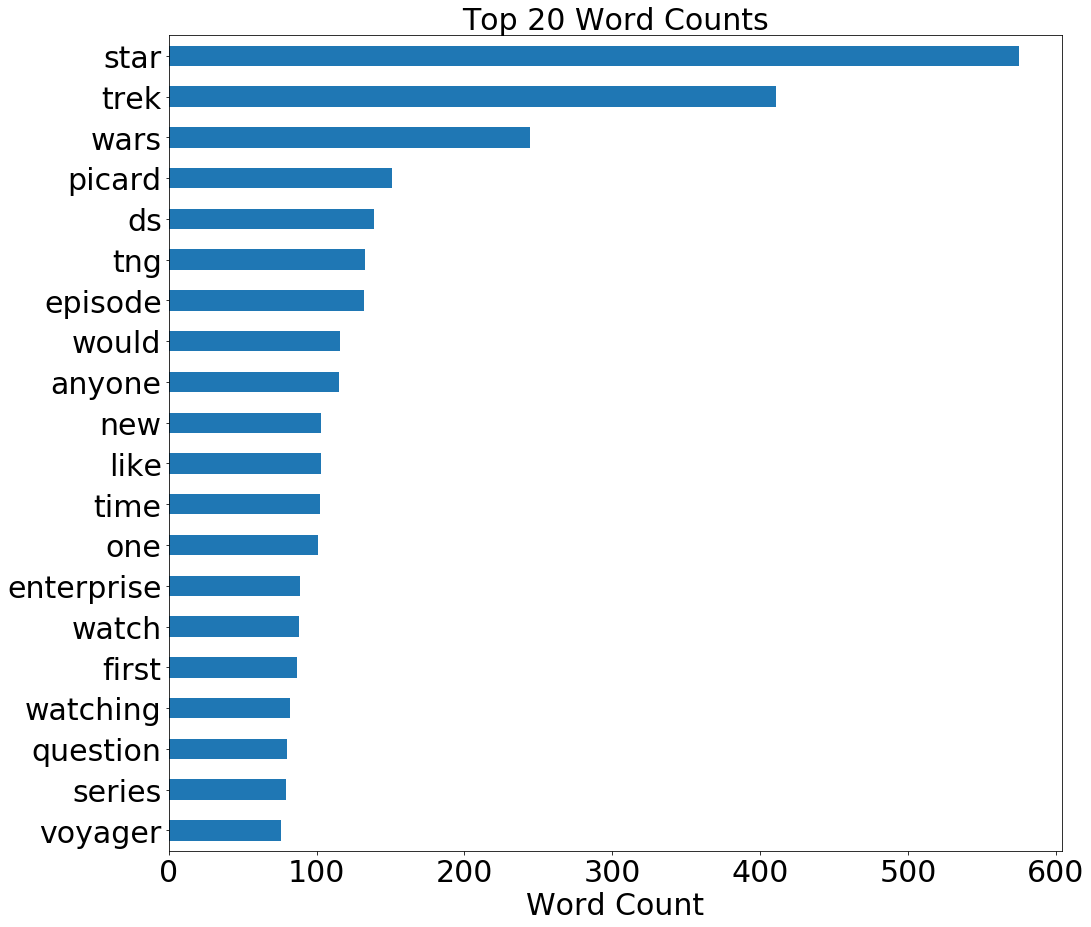

In [7]:
title_count.sum().sort_values(ascending = True).tail(20).plot(kind = 'barh', figsize = (16,15))
plt.title('Top 20 Word Counts',fontsize = 30);
plt.yticks(fontsize = 30)
plt.xticks(fontsize = 30)
plt.xlabel('Word Count',fontsize = 30);


The words that are highest valued seem to come from the Star Trek subreddit more so than the Star Wars subreddit. This is another indicator of a class imbalance but it is not that significant.

## Modelling and Validation

In [8]:
y = data['is_startrek']
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y,random_state = 42)

In [9]:
X_train.shape

(2178,)

I will be comparing the performance of a naive-bayes multinomial classification model with a logistic regression model. A multinomialNB was used as the countvectorizer yields datapoints that are positive discrete values. In further modelling, a gaussianNB model should be used if a TFIDF vectorizer is implemented. 

##### Logistic Regression

In [10]:
pipe_log_cvec = Pipeline([('cvec',CountVectorizer()),
                         ('logreg', LogisticRegression(penalty = 'l1',solver = 'liblinear', random_state = 42))])
cvec_params = {'cvec__stop_words':[None,'english'],
              'cvec__ngram_range':[(1,1),(1,2),(1,3)]}
grid_log_cvec = GridSearchCV(pipe_log_cvec,
                         cvec_params,
                         cv=3)

**Model Parameters**  
Using a pipeline to feed in a countvectorized logistic regression into a gridsearch, I will be able to compare multiple parameters to reach the best model.  
For the logistic regression I used a lasso penalty due to the large number of features that will be in this model, and a liblinear solver because the dataset is relatively small at 2178 rows.  
**Vectorizer Paramters**  
Additionally, I've included the combination of the English stopword library as well as no stopwords as well as a unigram, bigram, and trigram ranges so that movie and show titles, such as 'Wrath of Khan' and 'Rise of Skywalker', and words specific to each franchise, such as 'lightsaber' and 'phaser' will be accounted for. These parameters will also be implemented in countvectors used in future models. 

In [11]:
grid_log_cvec.fit(X_train,y_train);

The best parameters from the logistic regression were a bigram range, and the implementation of the `english` stopwords from nltk stopwords library.

In [12]:
grid_log_cvec.best_params_

{'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}

In [13]:
#generating predicted values or confusion matrix
log_pred = grid_log_cvec.predict(X_test)

In [14]:
cm_log = confusion_matrix(y_test,log_pred)
cm_log_pred = pd.DataFrame(cm_log, columns = ['predicted Star Trek','predicted Star Wars'],
index = ['actual Star Trek','actual Star Wars'])

In [15]:
cm_log_pred

,predicted Star Trek,predicted Star Wars
actual Star Trek,206,68
actual Star Wars,14,439


In [16]:
#Confusion matrix for logistic regression model
tn,fp,fn,tp = cm_log.ravel()

In [17]:
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)
train_score=grid_log_cvec.best_estimator_.score(X_train,y_train)
test_score=grid_log_cvec.best_estimator_.score(X_test,y_test)
print(f'Train score:{train_score}, Test score:{test_score}')
print(f'Specificity: {round(specificity,4)}')
print(f'Sensitivity: {round(sensitivity,4)}')

Train score:0.9146005509641874, Test score:0.8872077028885832
Specificity: 0.7518
Sensitivity: 0.9691


The Logistic Regression model outperformed the baseline model by approximately 27% and exhibited an ideal fit with low bias and low variance between training and testing scores. The sensitivity score of 97% also shows that the model is great for classifying whether an article title is pertinent to Star Trek. However, the specificity is a bit lower at 75%. This is probably due to the class imbalance of the original data. In further optimization of the logistic model, bootstrapping the training data would help fix this issue. 

##### Multinomial NaiveBayes Model

In [18]:
pipe_nb_cvec = Pipeline([('cvec',CountVectorizer()),('multinb', MultinomialNB())])
grid_nb_cvec = GridSearchCV(pipe_nb_cvec,
                            cvec_params,
                            cv = 3)

In [19]:
grid_nb_cvec.fit(X_train,y_train);

The best parameters for the countvectorizer yielded a bigram range, but interestingly did not require any stopwords in the Multinomaial Naive Bayes model.

In [20]:
grid_nb_cvec.best_params_

{'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}

In [21]:
#generating predicted values
nb_pred = grid_nb_cvec.predict(X_test)

In [22]:
cm_nb = confusion_matrix(y_test, nb_pred)
cm_nb_pred = pd.DataFrame(cm_nb, columns = ['predicted Star Trek','predicted Star Wars'],
index = ['actual Star Trek','actual Star Wars'])

In [23]:
cm_nb_pred

,predicted Star Trek,predicted Star Wars
actual Star Trek,230,44
actual Star Wars,28,425


In [24]:
#Confusion matrix for Naive-Bayes model
tn,fp,fn,tp = cm_nb.ravel()

In [25]:
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)
train_score=grid_nb_cvec.best_estimator_.score(X_train,y_train)
test_score=grid_nb_cvec.best_estimator_.score(X_test,y_test)
print(f'Train score:{train_score}, Test score:{test_score}')
print(f'Specificity: {round(specificity,4)}')
print(f'Sensitivity: {round(sensitivity,4)}')

Train score:0.9857667584940312, Test score:0.9009628610729024
Specificity: 0.8394
Sensitivity: 0.9382


The multinomial Naive Bayes model outperformed the baseline and also outperformed the logistic regression. Despite the class imbalance, sensitivity and specificity values yielded much higher scores than the logistic regression. Therefore, this should be the model implemented to classify the client's submissions. 

# Conclusions & Further Improvements 

After running both a logistic regression and a Naive-Bayes classification model, it was evident that the Naive-Bayes model was the more effective model to use. The original data that was pulled from reddit suffered from a class imbalance due to the more frequent posts on the Star Trek subreddit vs the Star Wars subreddit. This is most likely due to the more recent airing of the tv show, Star Trek: Picard on January 23, 2020. While the latest Star Wars movie, Star Wars: The Rise of Skywalker was also released recently, it was released almost a full month earlier on December 20, 2019. Additionally, the movie didn't perform as well as the Star Trek Picard show with a 52% rating on Rotten Tomatoes vs a 90% rating for Star Trek: Picard. In order to improve our model, bootstrapping our dataset to increase the proportions of Star Wars posts would be useful in mitigating the effects of the imbalance, but even without doing so, the Naive-Bayes model performed better than the logistic regression model. Therefore, the Naive-Bayes predictive classification model will be our production model for the client. 

Further optimization to the production model will involve vectorizing the data with a Tfidf Vectorizer in order to track relevance of each individual word as opposed to just the term frequency itself.

##### Sources:
- [Star Trek: Picard Rating](https://www.rottentomatoes.com/tv/star_trek_picard)
- [Star Wars: The Rise of Skywalker](https://www.rottentomatoes.com/m/star_wars_the_rise_of_skywalker)
- [Model Comparison](https://dataespresso.com/en/2017/10/24/comparison-between-naive-bayes-and-logistic-regression/)